## Analysis of access data

> **Developing some interactive visualisations that highlight key statistics from our access data.** This consists of a series of spreadsheets, providing details of applications to SYNTHESYS for researcher visits to participating Natural History Collections across Europe, and the research outputs (primarily publications) generated through these visits. Depending on the consistency of these datasets we will try to provide them through to the first iteration of SYSTHESYS so they will cover about 4k funded research projects. Various aspects of these data (including unsuccessful applications) might be explored and we will work with you to highlight these, alongside a handful of high profile projects which we may seek to promote.

## 1. Read and understand the access data

In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("./FullExportAnon.csv", encoding="mac_cyrillic")  # this dataset is private!

In [3]:
# Column names in dataframe
df.keys()

Index(['User_Code', 'Call_Submitted', 'Applicant_Age_Visit_Start',
       'User_NHM.Gender', 'User_NHM.Researcher_status', 'HostInstName1',
       'User_NHM.Home_Institution_Name', 'User_NHM.Home_Institution_Type',
       'User_NHM.Home_Institution_Town',
       'User_NHM.Home_Institution_Country_code',
       'NHM_Disciplines.DisciplineName', 'ProjectsView.Project_Discipline_ID',
       'NHM_Specific_Disciplines.SpecificDisciplineName',
       'ProjectsView.Project_Specific_Discipline_ID', 'ProjectStart_Year',
       'ProjectStart_Quarter', 'ProjectStart_Month', 'ProjectStart_Day',
       'ProjectsView.length_of_visit', 'NHM_Installation_Use.Acceptance',
       'NHM_Installation_Use.Amount_of_Access_Delivered',
       'NHM_Installation_Use.Infrastructure_Short_Name',
       'NHM_Installation_Use.Installation_ID',
       'NHM_Installation_Use.Installation_Long_Name',
       'NHM_Installation_Use.Installation_Short_Name',
       'ProjectsView.Visit_Funded_Previously', 'SynthRound', 'TAF

In [4]:
df.head()

,User_Code,Call_Submitted,Applicant_Age_Visit_Start,User_NHM.Gender,User_NHM.Researcher_status,HostInstName1,User_NHM.Home_Institution_Name,User_NHM.Home_Institution_Type,User_NHM.Home_Institution_Town,User_NHM.Home_Institution_Country_code,...,NHM_Installation_Use.Acceptance,NHM_Installation_Use.Amount_of_Access_Delivered,NHM_Installation_Use.Infrastructure_Short_Name,NHM_Installation_Use.Installation_ID,NHM_Installation_Use.Installation_Long_Name,NHM_Installation_Use.Installation_Short_Name,ProjectsView.Visit_Funded_Previously,SynthRound,TAF_ID,TAF_Name
0,User0,1,32,M,PDOC,NRM,Natural History Museum,RES,London,GB,...,True,10,SE-TAF,1,NRM,NRM,False,R2,1,SE-TAF
1,User0,4,39,M,EXP,National Museum Prague,University of Cambridge,UNI,Cambridge,GB,...,True,5,CZ-TAF,1,NMP Collections and Facilities,NMP,False,R3,1,CZ-TAF
2,User0,4,39,M,EXP,NRM,University of Cambridge,UNI,Cambridge,GB,...,True,7,SE-TAF,1,NRM,NRM,False,R3,1,SE-TAF
3,User1,1,40,M,PGR,NHM,University of Basel,UNI,Basel,CH,...,True,15,GB-TAF,3,NHM Collections and Laboratories,NHM COL MOL,False,R2,1,GB-TAF
4,User10,2,56,M,EXP,RBINS,NATIONAL MUSEUM WALES,RES,CARDIFF,GB,...,True,5,BE-TAF,1,RBINS,RBINS,False,R2,1,BE-TAF


In [5]:
print(f'Access dataset has {len(df):,g} rows')

Access dataset has 5,862 rows


In [6]:
unique_users = len(df['User_Code'].unique())
print(f"User_Code, the Anonymised user id column has {unique_users:,g} unqique entries")

User_Code, the Anonymised user id column has 2,474 unqique entries


In [7]:
d_users = Counter(df['User_Code']).most_common() # count and order the users

In [8]:
d_users[0:10]  # The top 10 users by number of appearances in the dataset

[('User1124', 23),
 ('User2023', 23),
 ('User1742', 22),
 ('User714', 22),
 ('User1553', 18),
 ('User1669', 18),
 ('User1695', 18),
 ('User1563', 16),
 ('User338', 16),
 ('User476', 15)]

In [9]:
reccurence = [user_reccurence[1] for user_reccurence in d_users]

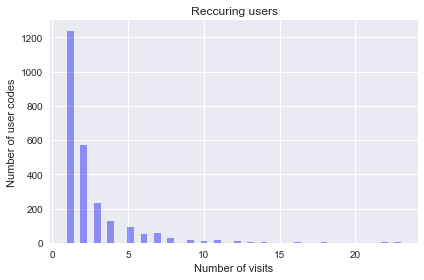

In [10]:
# Plot a simple histogram with binsize determined automatically
sns.distplot(reccurence, kde=False, color="b", axlabel='Number of visits')
plt.title("Reccuring users")
plt.ylabel("Number of user codes")
plt.tight_layout()

### What is actually diffrent when user_codes are the same?

In [11]:
mask = df['User_Code'] == 'User1124'
df[mask].head()

,User_Code,Call_Submitted,Applicant_Age_Visit_Start,User_NHM.Gender,User_NHM.Researcher_status,HostInstName1,User_NHM.Home_Institution_Name,User_NHM.Home_Institution_Type,User_NHM.Home_Institution_Town,User_NHM.Home_Institution_Country_code,...,NHM_Installation_Use.Acceptance,NHM_Installation_Use.Amount_of_Access_Delivered,NHM_Installation_Use.Infrastructure_Short_Name,NHM_Installation_Use.Installation_ID,NHM_Installation_Use.Installation_Long_Name,NHM_Installation_Use.Installation_Short_Name,ProjectsView.Visit_Funded_Previously,SynthRound,TAF_ID,TAF_Name
318,User1124,1,72,M,EXP,Museum National dТHistoire Naturelle,"in retirement, member of Czech Entomological S...",OTH,Adamov u Brna,CZ,...,True,5,FR-TAF,1,Collections,COLL,False,R3,1,FR-TAF
319,User1124,1,72,M,EXP,Museum National dТHistoire Naturelle,"in retirement, member of Czech Entomological S...",OTH,Adamov u Brna,CZ,...,True,0,FR-TAF,2,Facilities,INST,False,R3,1,FR-TAF
320,User1124,2,69,M,EXP,BGBM,"in retirement, member of Czech Entomological S...",OTH,Adamov u Brna,CZ,...,True,0,DE-TAF,1,BGBM Collections,BGBM COL,False,R2,1,DE-TAF
321,User1124,2,69,M,EXP,MfN,"in retirement, member of Czech Entomological S...",OTH,Adamov u Brna,CZ,...,True,5,DE-TAF,3,MfN Collections,MfN COL,False,R2,1,DE-TAF
322,User1124,2,73,M,EXP,MfN,"in retirement, member of Czech Entomological S...",OTH,Adamov u Brna,CZ,...,True,5,DE-TAF,3,MfN Collections,MfN COL,True,R3,1,DE-TAF


In [12]:
# Example of the most frequently appearing users data:

def give_date(year, month, day):
    months = {'January': 1, 'Feburary': 2, 'March':3, 'April':4, 'May':5,
              'June':6, "July":7, "August":8,"September":9, "October":10,
              "November":11, "December":12}
    return pd.datetime(int(year), months['November'], int(day))



for index, row in df[mask].iterrows():
    date = give_date(row['ProjectStart_Year'], row['ProjectStart_Month'], row['ProjectStart_Day'])
    age = row['Applicant_Age_Visit_Start']
    to_use = row['NHM_Installation_Use.Installation_Long_Name']
    calls = row['Call_Submitted']
    print('Start:',date.date(), "age:",age, calls, to_use)

Start: 2014-11-16 age: 72 1 Collections
Start: 2014-11-16 age: 72 1 Facilities
Start: 2011-11-09 age: 69 2 BGBM Collections
Start: 2011-11-09 age: 69 2 MfN Collections
Start: 2015-11-01 age: 73 2 MfN Collections
Start: 2011-11-10 age: 69 2 Collections
Start: 2015-11-22 age: 73 2 Collections
Start: 2015-11-01 age: 73 2 SGN Collections
Start: 2012-11-14 age: 70 3 NHM Analytical Facilities
Start: 2012-11-14 age: 70 3 NHM Collections and Laboratories
Start: 2013-11-15 age: 71 4 RBINS
Start: 2013-11-15 age: 71 4 RMCA
Start: 2017-11-20 age: 75 4 SGN Collections
Start: 2007-11-05 age: 65 6 NHM Collections
Start: 2007-11-05 age: 65 6 NHM Analytical Facilities
Start: 2008-11-15 age: 66 8 Collections
Start: 2008-11-15 age: 66 8 SEM
Start: 2008-11-15 age: 66 8 Molecular Laboratory
Start: 2008-11-15 age: 66 8 Analytical Facilities
Start: 2008-11-15 age: 66 8 Mass Spectrometry
Start: 2009-11-15 age: 67 9 NGB
Start: 2009-11-15 age: 67 9 RBINS
Start: 2009-11-15 age: 67 9 RMCA


### What are the unique codes in the data and their meaning?

In many places the data have shorthand codes, we will need to relate this shorthand to their actual meaning.

I can also use the Counter object here to get a first-pass idea of the frequency of each item.

In [13]:
Counter(df['Call_Submitted']) # Not sure what this is exactly.

Counter({1: 990,
         2: 1033,
         3: 1029,
         4: 1183,
         5: 274,
         6: 301,
         7: 322,
         8: 542,
         9: 188})

In [14]:
Counter(df['User_NHM.Home_Institution_Type'])

Counter({'OTH': 409, 'PRV': 3, 'RES': 1817, 'SME': 45, 'UNI': 3588})

Different classifications of institute types. Will need to ask for specific definitions.

In [15]:
Counter(df['User_NHM.Researcher_status'])

Counter({'EXP': 2000, 'PDOC': 1944, 'PGR': 1738, 'TEC': 55, 'UND': 125})

Different researcher carrear levels (e.g. PDOC = postdoctorate investigator), will need to ask them for specific definitions.

In [16]:
Counter(df['Call_Submitted'])

Counter({1: 990,
         2: 1033,
         3: 1029,
         4: 1183,
         5: 274,
         6: 301,
         7: 322,
         8: 542,
         9: 188})

I guess this means the number of times a unique researcher has applied for funding with the same combination of variables (will need to confirm this). If true, this might mean that if their researcher status changes, or affiliation, they would be given a different ID?


'Applicant_Age_Visit_Start'

'User_NHM.Gender'
      
'User_NHM.Researcher_status'
      
'HostInstName1',
     
'User_NHM.Home_Institution_Name'

'User_NHM.Home_Institution_Type'
     
'User_NHM.Home_Institution_Town'
     
'User_NHM.Home_Institution_Country_code'

### Simple stats to understand the data

* Age of the users
* Gender

In [17]:
def distribution(df, key, xlabel=None, ylabel=None, title=None):
    # Return a distribution plot e.g. to show the Age of users in a df object
    sns.distplot(df[key].values, kde=True, color="b", axlabel=xlabel)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

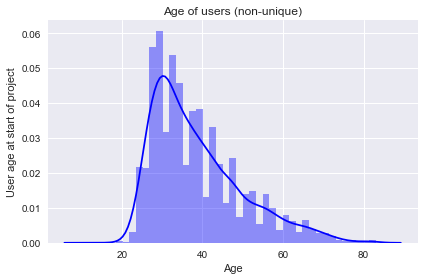

In [18]:
# age of users for all collection
distribution(df, key='Applicant_Age_Visit_Start', ylabel="User age at start of project", xlabel='Age',
             title="Age of users (non-unique)")

In [19]:
def donut_plot(df, column_key, fix_keys=None, colors=None ):
    """Pass an arbritrary dataframe with a key, and optional color scheme.
    Return a donut plot.
    """
    gender_counts = Counter(df[column_key])
    labels = []
    values = []
    if not fix_keys:
        for key in gender_counts:
            labels.append(key)
            values.append(gender_counts[key])
    else:
        for key in fix_keys:
            labels.append(key)
            values.append(gender_counts[key])        
    
    #The slices will be ordered and plotted counter-clockwise.
    #explode = (0, 0)
    explode = 0
    explode = (explode,) * len(labels)
    plt.pie(values, explode=explode, labels=labels,colors=colors,
            autopct='%1.1f%%', shadow=False)
    centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.75)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.axis('equal')
    plt.title("Gender balance")
    plt.show() 

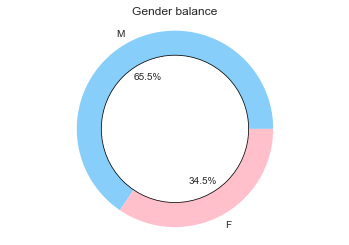

In [20]:
# Gender balance of all users
donut_plot(df, column_key='User_NHM.Gender', fix_keys=["M","F"], colors=['lightskyblue', 'pink'])

In [21]:
def group_stats(df):
    """For a dataframe print some stats we care about"""
    count = df['Applicant_Age_Visit_Start'].describe()['count']
    mean_age = df['Applicant_Age_Visit_Start'].describe()['mean']
    stdev_age = df['Applicant_Age_Visit_Start'].describe()['std']
    print(f"{count:g} visits. Average age = {mean_age:3.1f}±{stdev_age:3.1f}")
    return

In [22]:
group_stats(df)

5862 visits. Average age = 38.7±11.2


In [23]:
def visits_per_country(df):
    """Pass in a dataframe and return a plot of visitors per country"""
    countries = Counter(df['User_NHM.Home_Institution_Country_code']).most_common()
    countries
    places = []
    visits = []
    for c,num in countries:
        places.append(c)
        visits.append(num)
    country_visists = pd.DataFrame(countries, columns=['country','visits'])
    f, ax = plt.subplots(figsize=(6, 10))
    # Plot the total crashes
    sns.set_color_codes("pastel")
    sns.barplot(x="visits", y="country", data=country_visists,
                label="Total", color="b")
    ax.set(ylabel='Country', xlabel="number of visits", title="Visits by country")
    sns.despine(left=True, bottom=True)
    plt.show()


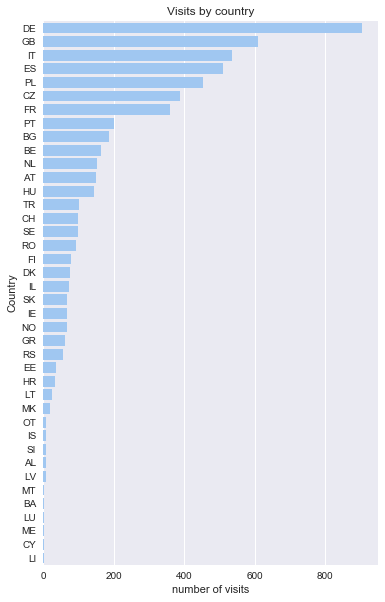

In [24]:
visits_per_country(df)

### Let's see how these properties change by discipline


DISCIPLINE: Earth sciences & environment
3323 visits. Average age = 37.8±10.3


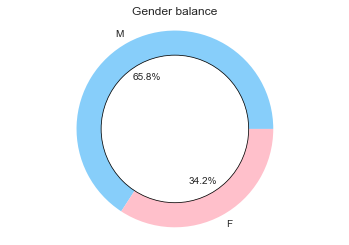

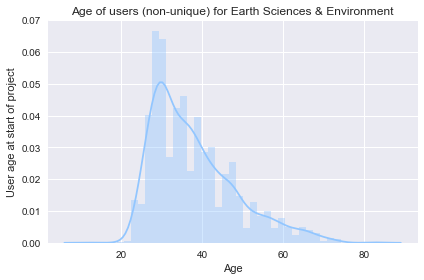

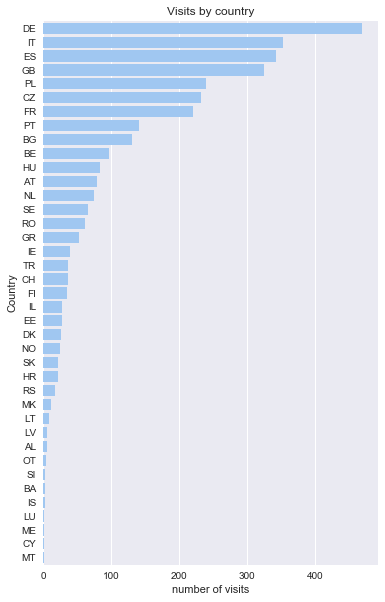


DISCIPLINE: Life sciences & biotech
2465 visits. Average age = 39.9±12.2


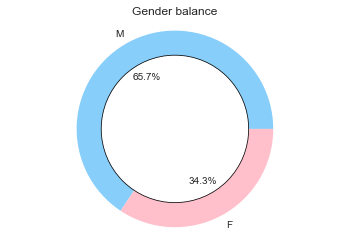

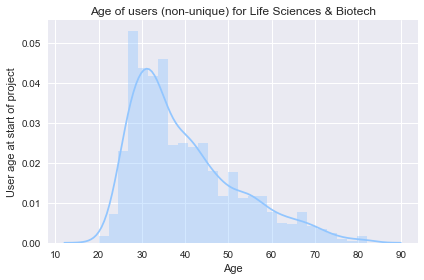

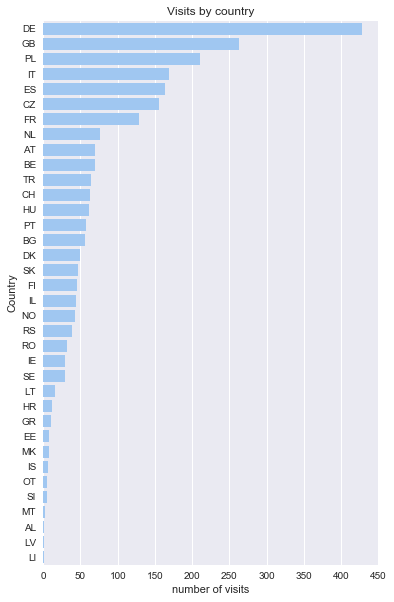


DISCIPLINE: Humanities
38 visits. Average age = 37.4±8.9


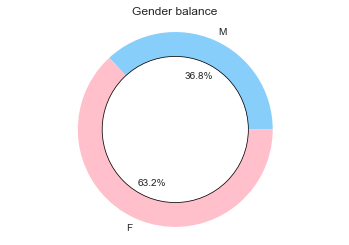

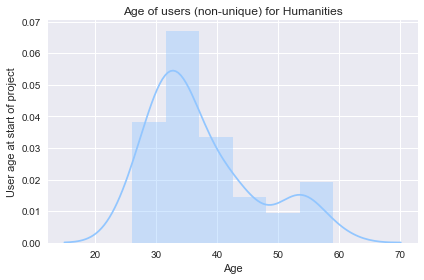

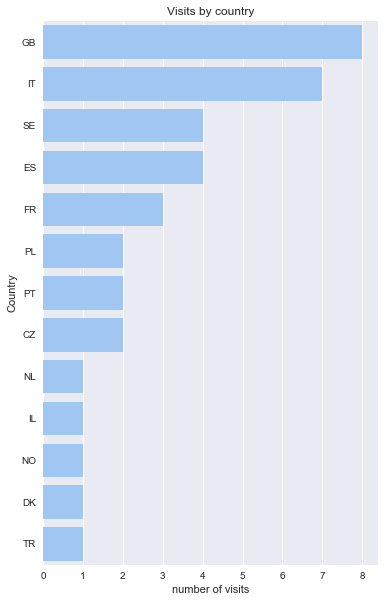


DISCIPLINE: Information & communication technologies
8 visits. Average age = 29.5±7.4


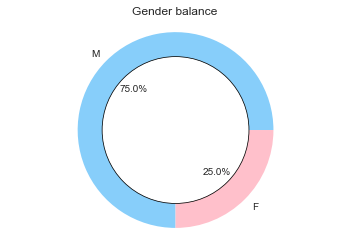

Only 8 entries for discipline. Not sufficent for histogram.


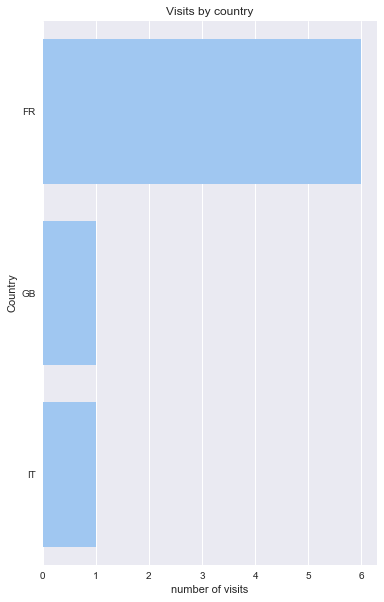


DISCIPLINE: Social sciences
15 visits. Average age = 30.9±5.5


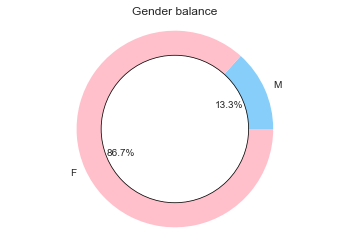

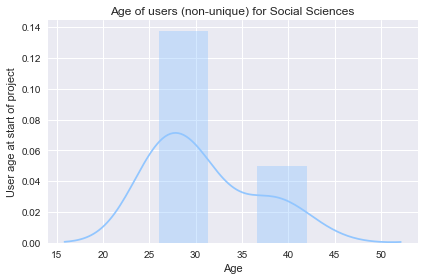

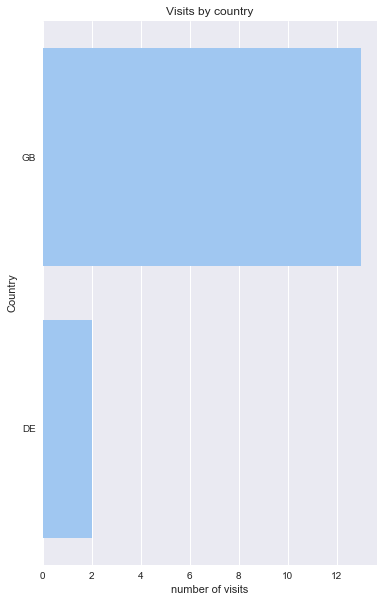


DISCIPLINE: Material sciences
3 visits. Average age = 44.3±4.0


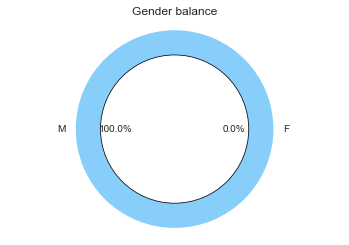

Only 3 entries for discipline. Not sufficent for histogram.


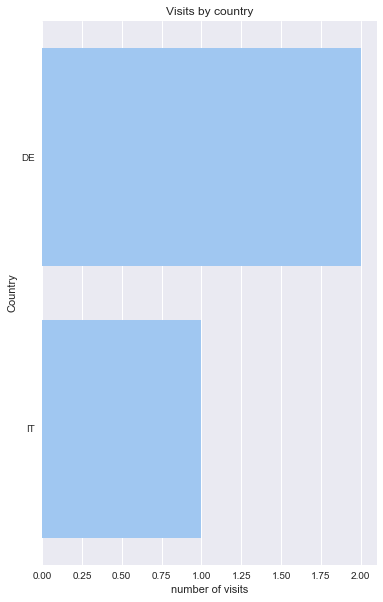


DISCIPLINE: Physics
1 visits. Average age = 41.0±nan


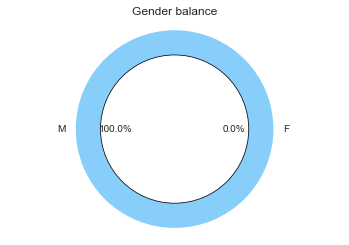

Only 1 entries for discipline. Not sufficent for histogram.


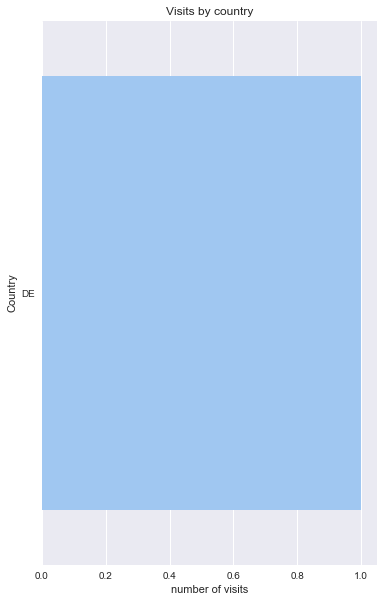


DISCIPLINE: Engineering & technology
5 visits. Average age = 46.6±9.8


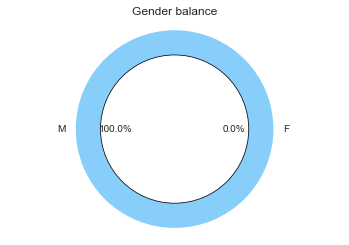

Only 5 entries for discipline. Not sufficent for histogram.


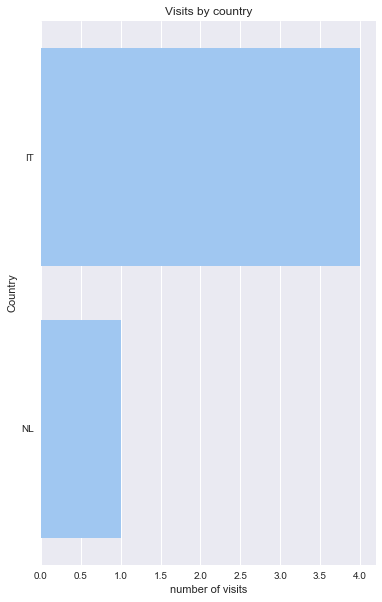

In [25]:
for discipline in df['NHM_Disciplines.DisciplineName'].unique():
    if isinstance(discipline, str):
        print(f"\nDISCIPLINE: {discipline.capitalize()}")
        mask = df['NHM_Disciplines.DisciplineName'] == discipline
        group_stats(df[mask])
        donut_plot(df[mask], column_key='User_NHM.Gender', 
                   fix_keys=["M","F"], colors=['lightskyblue', 'pink'])
        if len(df[mask]) > 10:
            distribution(df[mask], key='Applicant_Age_Visit_Start',
                         ylabel="User age at start of project", xlabel='Age',
                         title=f"Age of users (non-unique) for {discipline}")
        else:
            print(f"Only {len(df[mask])} entries for discipline. Not sufficent for histogram.")
        visits_per_country(df[mask])

### dev tests

Past this point is just mess...

In [ ]:
discpline_name = 'Earth Sciences & Environment'
mask = df['NHM_Disciplines.DisciplineName'] == discpline_name
test = df[mask]

In [ ]:
df['NHM_Disciplines.DisciplineName'].unique()

In [ ]:
test['Applicant_Age_Visit_Start'].describe()['count']
test['Applicant_Age_Visit_Start'].describe()['mean']
test['Applicant_Age_Visit_Start'].describe()['std']

In [ ]:
test['

In [ ]:
test.keys()

In [ ]:
# Ranked countries of Researcher origin by discipline

countries = Counter(test['User_NHM.Home_Institution_Country_code']).most_common()
countries

In [ ]:
places = []
visits = []

for c,num in countries:
    places.append(c)
    visits.append(num)

In [ ]:
country_visists = pd.DataFrame(countries, columns=['country','visits'])
country_visists.head()

Country break-down plot adapted from https://seaborn.pydata.org/examples/horizontal_barplot.html

In [ ]:

f, ax = plt.subplots(figsize=(6, 10))
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="visits", y="country", data=country_visists,
            label="Total", color="b")
ax.set(ylabel='Country', xlabel="number of visits", title="Visits by country")
sns.despine(left=True, bottom=True)
plt.show()


In [ ]:
visits_per_country(df)